In [27]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from numpy import *
from talib import ATR
from matplotlib import pyplot as plt
from factor_functions import get_resample, diy_ATR, get_atr

import sklearn
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [28]:
path = "factors2/"
dir_list = [x for x in os.listdir(path) if "spot" in x and "2017" not in x]
print("以下文件将被作为数据集")
dir_list

以下文件将被作为数据集


['BTCUSDTspot.csv',
 'BTCUSDTspot2018.csv',
 'ETHUSDTspot.csv',
 'ETHUSDTspot2018.csv']

# 数据处理

In [29]:
def get_whole_sample(path=path, n=6):
    df_lis = list()
    for csv_file in dir_list:
        df = pd.read_csv(path+csv_file, index_col=0).drop(columns=['Unnamed: 0'])
        
        if 'Unnamed: 0.1' in df.columns:
            df = df.drop(columns=['Unnamed: 0.1'])
            
        df = get_atr(df)
        df['future_return'] = df.close.shift(-n).values/df.close.values - 1
        
        df['r1'] = df['close'].pct_change()/df['atr']
        df['r2'] = df.close/df['close'].shift(2) - 1
        df['r12'] = df.close/df['close'].shift(12) - 1
        
        print(csv_file, df.shape)
        df_lis.append(df)
        
    df = pd.concat(df_lis)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df = df.set_index(df['open_time'])
    print("总样本：", df.shape)
    return df

In [30]:
df = get_whole_sample()

BTCUSDTspot.csv (311170, 205)
BTCUSDTspot2018.csv (82795, 205)
ETHUSDTspot.csv (309240, 205)
ETHUSDTspot2018.csv (81673, 205)
总样本： (784878, 205)


In [31]:
mean_ = df['future_return'].mean()
std_ = df['future_return'].std()
n = 25
print("原始数据：")
print(len(df))
print("异常值数量：")
print(len(df[abs(df['future_return'] - mean_) > std_ * n]))

原始数据：
784878
异常值数量：
13


原始数据分布图


<AxesSubplot:xlabel='open_time'>

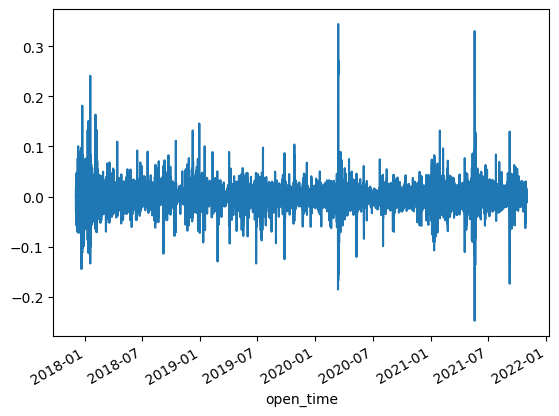

In [32]:
max_ = df[abs(df['future_return'] - mean_ )<= std_ * n]['future_return'].max()
min_ = df[abs(df['future_return'] - mean_ )<= std_ * n]['future_return'].min()
print("原始数据分布图")
df['future_return'].plot()

盖帽后数据分布图


<AxesSubplot:xlabel='open_time'>

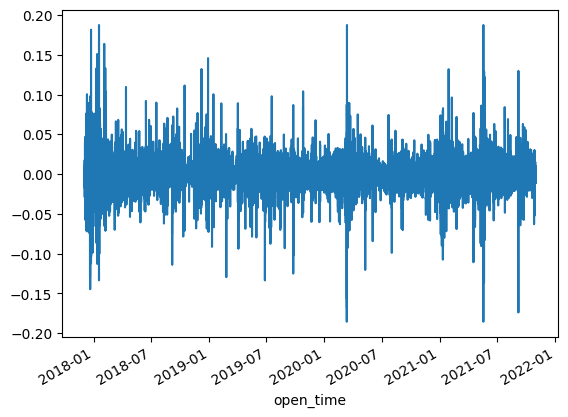

In [33]:
df.loc[df[df['future_return'] - mean_ >= std_ * n].index.to_list(), "future_return"] = max_
df.loc[df[df['future_return'] - mean_ <= -std_ * n].index.to_list(), "future_return"] = min_
print("盖帽后数据分布图")
df['future_return'].plot()

In [34]:
nan = df.isnull().sum()/df.shape[0]
nan = pd.DataFrame(nan)
nan.columns=['nan_percent']
print("空值情况")
nan.sort_values('nan_percent').tail(10)
print("去空值前",df.shape)
df = df.dropna()
print("去空值后",df.shape)

空值情况
去空值前 (784878, 205)
去空值后 (784806, 205)


In [35]:
print("无限数情况")
is_finite = np.isfinite(df).all()
for i in range(len(is_finite)):
    if not is_finite[i]:
        print(df.columns[i], is_finite[i])
        col = df.columns[i]
        df[col] = df[col].replace(np.inf, 1000)
        df[col] = df[col].replace(-np.inf, -1000)
        print(col, "处理完成！")
print("已无极限值")

无限数情况
EFI10 False
EFI10 处理完成！
EFI08 False
EFI08 处理完成！
EFI05 False
EFI05 处理完成！
MVWAP_10 False
MVWAP_10 处理完成！
已无极限值


In [36]:
print("正在划分数据集")
df_train = df.loc[:'2020']
df_test = df.loc['2021':]

X_train = df_train.drop(columns=['future_return','open','high','low','volume','open_time']) # 'close',
y_train = df_train['future_return'].ravel()

X_test = df_test.drop(columns=['future_return','open','high','low','volume','open_time'])#'close',
y_test = df_test['future_return'].ravel()

print("训练集：",df_train.shape)
print("测试集：",df_test.shape)
print("划分完成！")

正在划分数据集
训练集： (617227, 205)
测试集： (167579, 205)
划分完成！


# PCA主成分分析

In [37]:
def get_pca_sample(X_train, X_test):
    print("正在标准化……")
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns)
    
    print("正在计算降维特征数量……")
    pca = PCA(n_components=len(X_train.columns))
    new_features = pca.fit_transform(X_train.values)
    variance_ratios = pca.explained_variance_ratio_
    print("预计降维后的因子数量为", len(variance_ratios[variance_ratios>0.001]))
    
    print("开始降维……")
    pca = PCA(n_components=len(variance_ratios[variance_ratios>0.001]))
    new_features = pca.fit_transform(X_train.values)
    X_train = pd.DataFrame(new_features, columns = ['alpha'+str(x+1) for x in range(new_features.shape[1])])
    print("X_train:", X_train.shape)
    
    new_features = pca.transform(X_test.values)
    X_test = pd.DataFrame(new_features, columns = ['alpha'+str(x+1) for x in range(new_features.shape[1])])
    print("X_test:", X_test.shape)
    print("降维完成……")
    return scaler, pca, X_train, X_test

scaler, pca, X_train, X_test = get_pca_sample(X_train, X_test)

正在标准化……
正在计算降维特征数量……
预计降维后的因子数量为 85
开始降维……
X_train: (617227, 85)
X_test: (167579, 85)
降维完成……


# 权重模型

In [12]:
w =1.1

In [ ]:
data_train = xgb.DMatrix(data=X_train,label= y_train)
data_test = xgb.DMatrix(data=X_test,label= y_test)

train_weight = [w if i < -0.01 else 1 for i in data_train.get_label()]
test_weight = [w if i < -0.01 else 1 for i in data_test.get_label()]

data_train2 = xgb.DMatrix(data=X_train,label= y_train,weight=train_weight)
data_test2 = xgb.DMatrix(data=X_test,label= y_test, weight=test_weight)

In [ ]:
params = {'objective' :'reg:squarederror', 
          'eval_metric':'rmse',
        'colsample_bylevel':0.8,
        'colsample_bynode' : 0.8, 
        'colsample_bytree' : 0.8,
        'eta':0.08,
        'gamma':0,
        'max_depth':4,
        'min_child_weight':1000,
        'random_state':666}
a = xgb.train(params = params,dtrain=data_train2, num_boost_round=600)

In [ ]:
preds = a.predict(data_train)
rmse = np.sqrt(mse(y_train, preds))
print("The RMSE is %0.4f." % (rmse))
print("The in-sample R-squared of the XGB regression tree is %0.4f." % r2_score(y_train, preds))

d = pd.DataFrame(preds)
d = d.set_index(df_train.index)
d.columns = ['preds']
d['future_return'] = df_train['future_return']
fig, ax = plt.subplots(figsize=(20,20))

x = np.linspace(-0.4,0.4,len(d))
ax.plot([0]*len(d),x)

x = np.linspace(-0.2,0.2,len(d))
ax.plot(x,[0]*len(d))

ax.scatter(x=d['preds'],y=d['future_return'],color='r')
# ax.plot(x,x)
plt.show()

In [ ]:
preds = a.predict(data_test)
rmse = np.sqrt(mse(y_test, preds))
print("The out-of-sample RMSE is %0.4f." % (rmse))
print("The out-of-sample R-squared of the XGB regression tree is %0.4f." % r2_score(y_test, preds))

d = pd.DataFrame(preds)
d = d.set_index(df_test.index)
d.columns = ['preds']
d['future_return'] = df_test['future_return']
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
# d = d.loc['2020-05-19']
x = np.linspace(-0.4,0.4,len(d))
ax.plot([0]*len(d),x)

x = np.linspace(-0.2,0.2,len(d))
ax.plot(x,[0]*len(d))
ax.scatter(x=d['preds'],y=d['future_return'],color='r')
# ax.plot(x,x)
plt.show()

one = len(d[(d['preds']>0) & (d['future_return']>0)])
two = len(d[(d['preds']<0) & (d['future_return']>0)])
three = len(d[(d['preds']<0) & (d['future_return']<0)])
four = len(d[(d['preds']>0) & (d['future_return']<0)])

print("第一象限数量", one)
print("第二象限数量", two)
print("第三象限数量", three)
print("第四象限数量", four)
print("\n")
total = one + two + three + four

print("第一象限占比", one/total)
print("第二象限占比", two/total)
print("第三象限占比", three/total)
print("第四象限占比", four/total)
print("\n")
print("总胜率", (one+three)/total)
print("做多胜率", one/(one+four))
print("做空胜率", three/(two + three))

# 不带权重

In [38]:
data_train = xgb.DMatrix(data=X_train,label= y_train)
data_test = xgb.DMatrix(data=X_test,label= y_test)
print("正在训练模型……")
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                            colsample_bylevel=0.8,
                            colsample_bynode = 0.8, 
                            colsample_bytree = 0.8,
                            eta=0.08,
                            gamma=0,
                            max_depth=6,
                            min_child_weight=100,
                            n_estimators = 1000,
                            reg_alpha=1,
                            random_state=666)
xgb_reg.fit(X_train,y_train)
print("训练完成！")

正在训练模型……
训练完成！


样本内结果：
The in-sample RMSE is 0.0065.
The in-sample R-squared of the XGB regression tree is 0.2216.


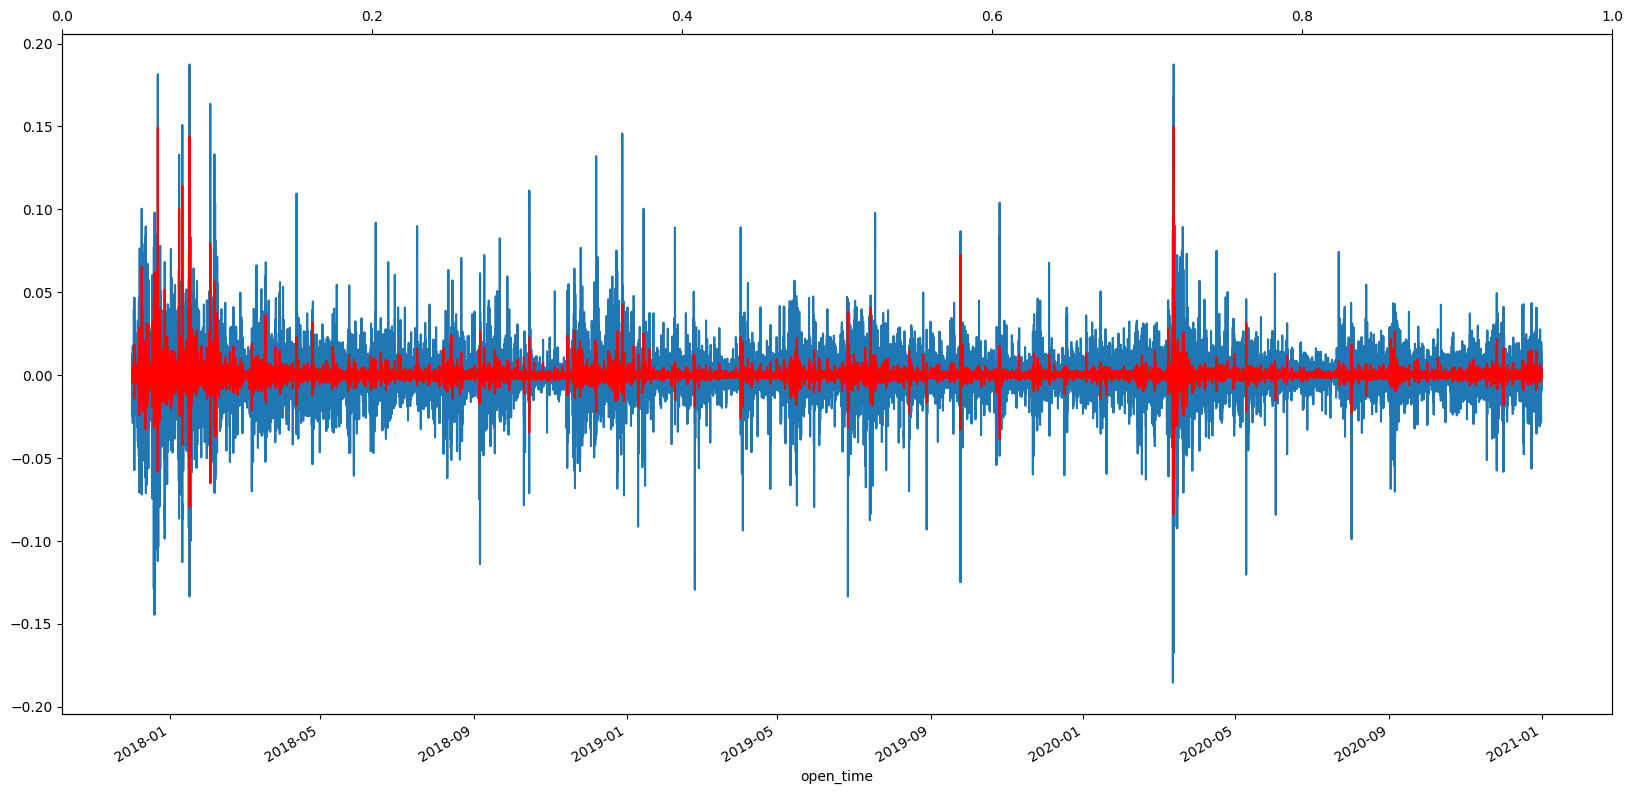

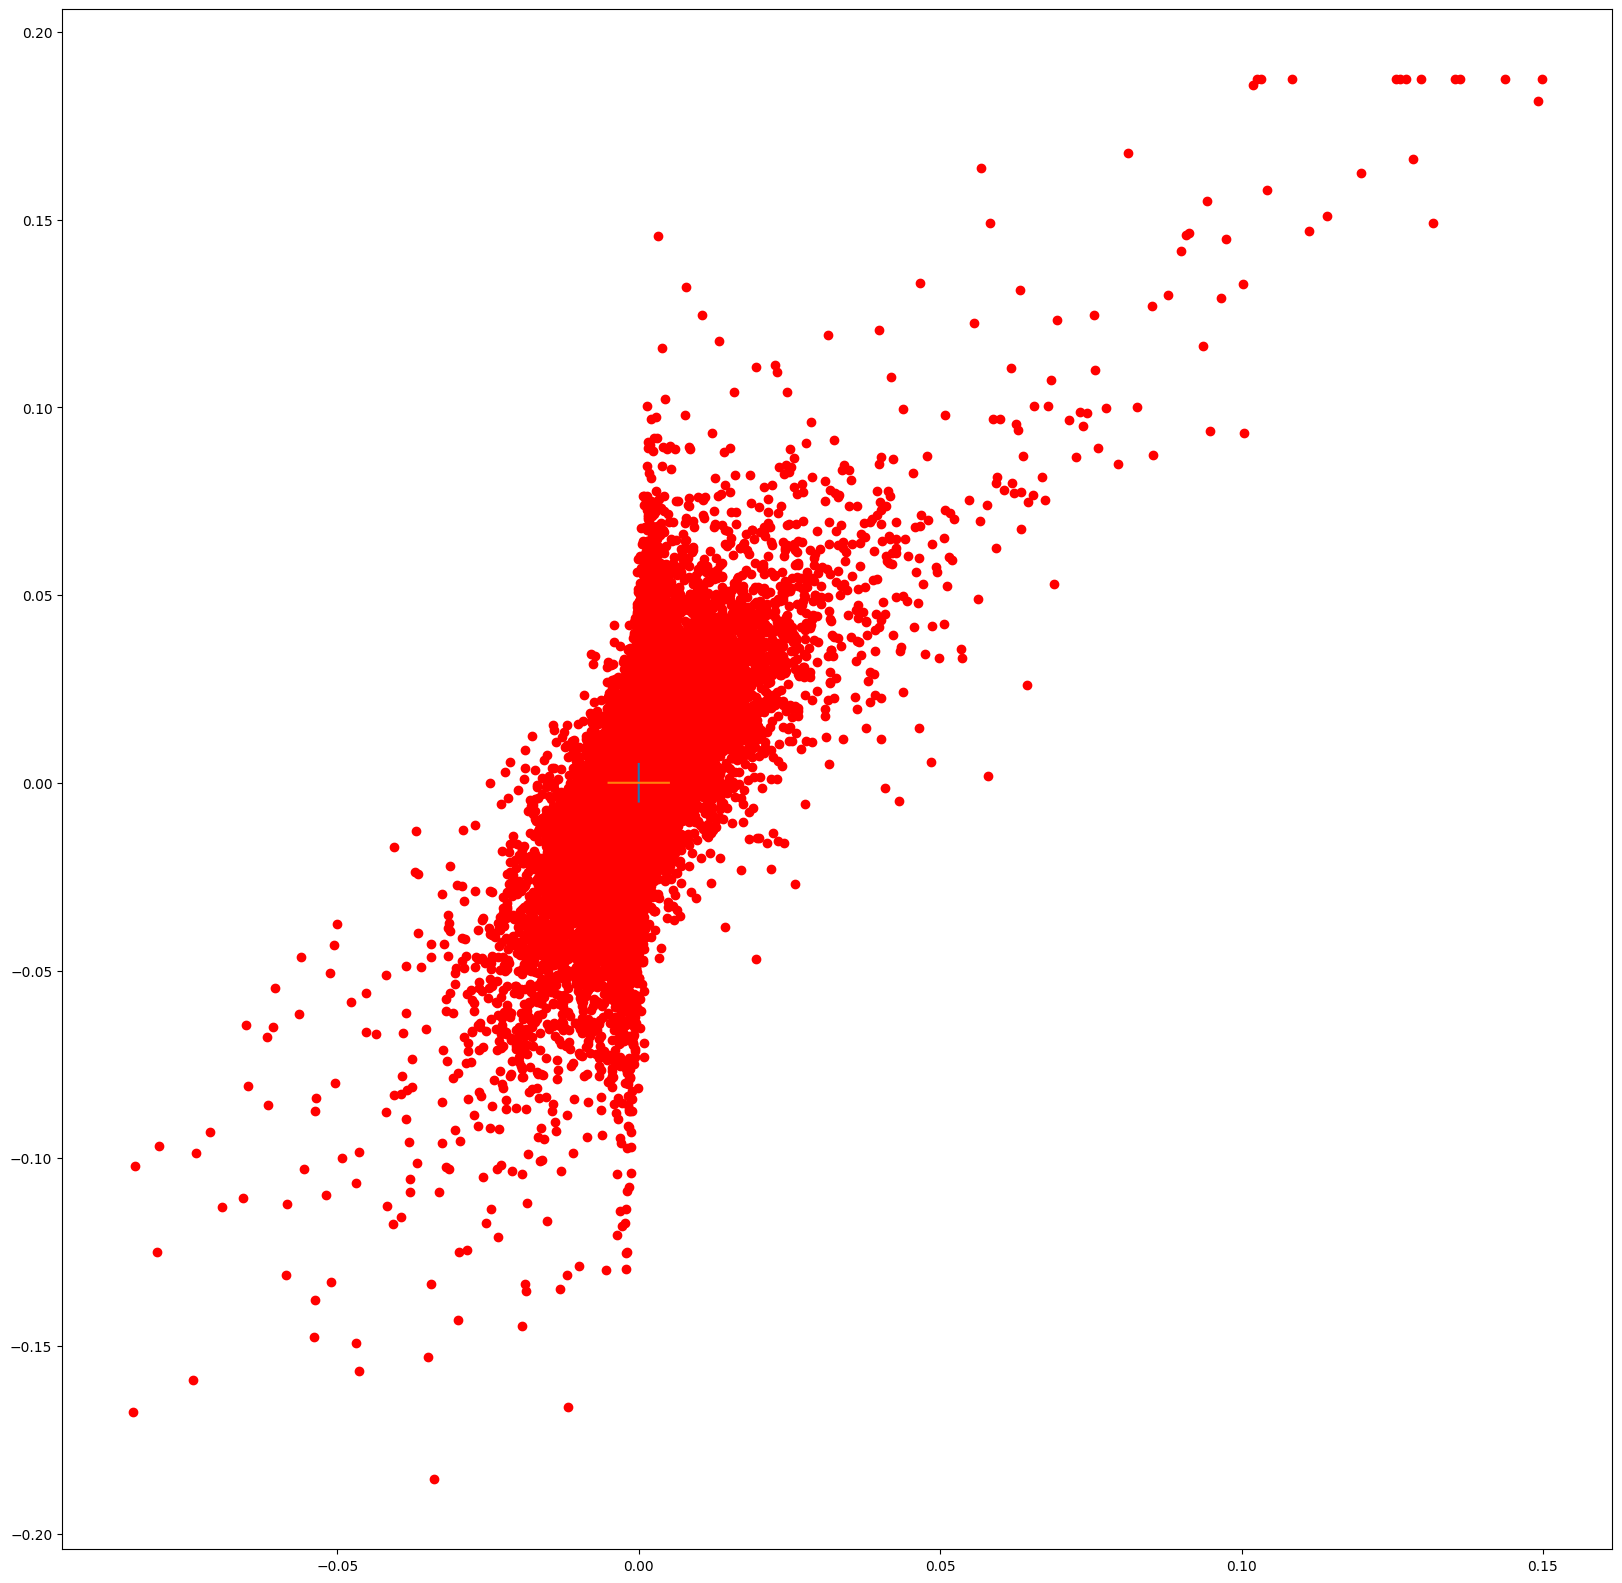

In [39]:
print("样本内结果：")

preds = xgb_reg.predict(X_train)
rmse = np.sqrt(mse(y_train, preds))
print("The in-sample RMSE is %0.4f." % (rmse))
print("The in-sample R-squared of the XGB regression tree is %0.4f." % r2_score(y_train, preds))

d = pd.DataFrame(preds)
d = d.set_index(df_train.index)
d.columns = ['preds']
d['future_return'] = df_train['future_return']
fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twiny()
d['future_return'].plot(ax=ax)
d['preds'].plot(ax=ax,secondary_y=False,color='r')
plt.show()

d = pd.DataFrame(preds)
d = d.set_index(df_train.index)
d.columns = ['preds']
d['future_return'] = df_train['future_return']
fig, ax = plt.subplots(figsize=(20,20))

x = np.linspace(-0.005,0.005,len(d))
ax.plot([0]*len(d),x)

x = np.linspace(-0.005,0.005,len(d))
ax.plot(x,[0]*len(d))

ax.scatter(x=d['preds'],y=d['future_return'],color='r')
# ax.plot(x,x)
plt.show()

In [40]:
one = len(d[(d['preds']>0) & (d['future_return']>0)])
two = len(d[(d['preds']<0) & (d['future_return']>0)])
three = len(d[(d['preds']<0) & (d['future_return']<0)])
four = len(d[(d['preds']>0) & (d['future_return']<0)])

print("第一象限数量", one)
print("第二象限数量", two)
print("第三象限数量", three)
print("第四象限数量", four)
print("\n")
total = one + two + three + four

print("第一象限占比", one/total)
print("第二象限占比", two/total)
print("第三象限占比", three/total)
print("第四象限占比", four/total)
print("\n")
print("总胜率", (one+three)/total)
print("做多胜率", one/(one+four))
print("做空胜率", three/(two + three))

第一象限数量 188046
第二象限数量 123595
第三象限数量 175911
第四象限数量 127714


第一象限占比 0.3056336608881362
第二象限占比 0.2008805947346351
第三象限占比 0.28591048424583837
第四象限占比 0.20757526013139033


总胜率 0.5915441451339746
做多胜率 0.595534583227768
做空胜率 0.5873371485045374


样本外
The out-of-sample RMSE is 0.0087.
The out-of-sample R-squared of the XGB regression tree is -0.0752.


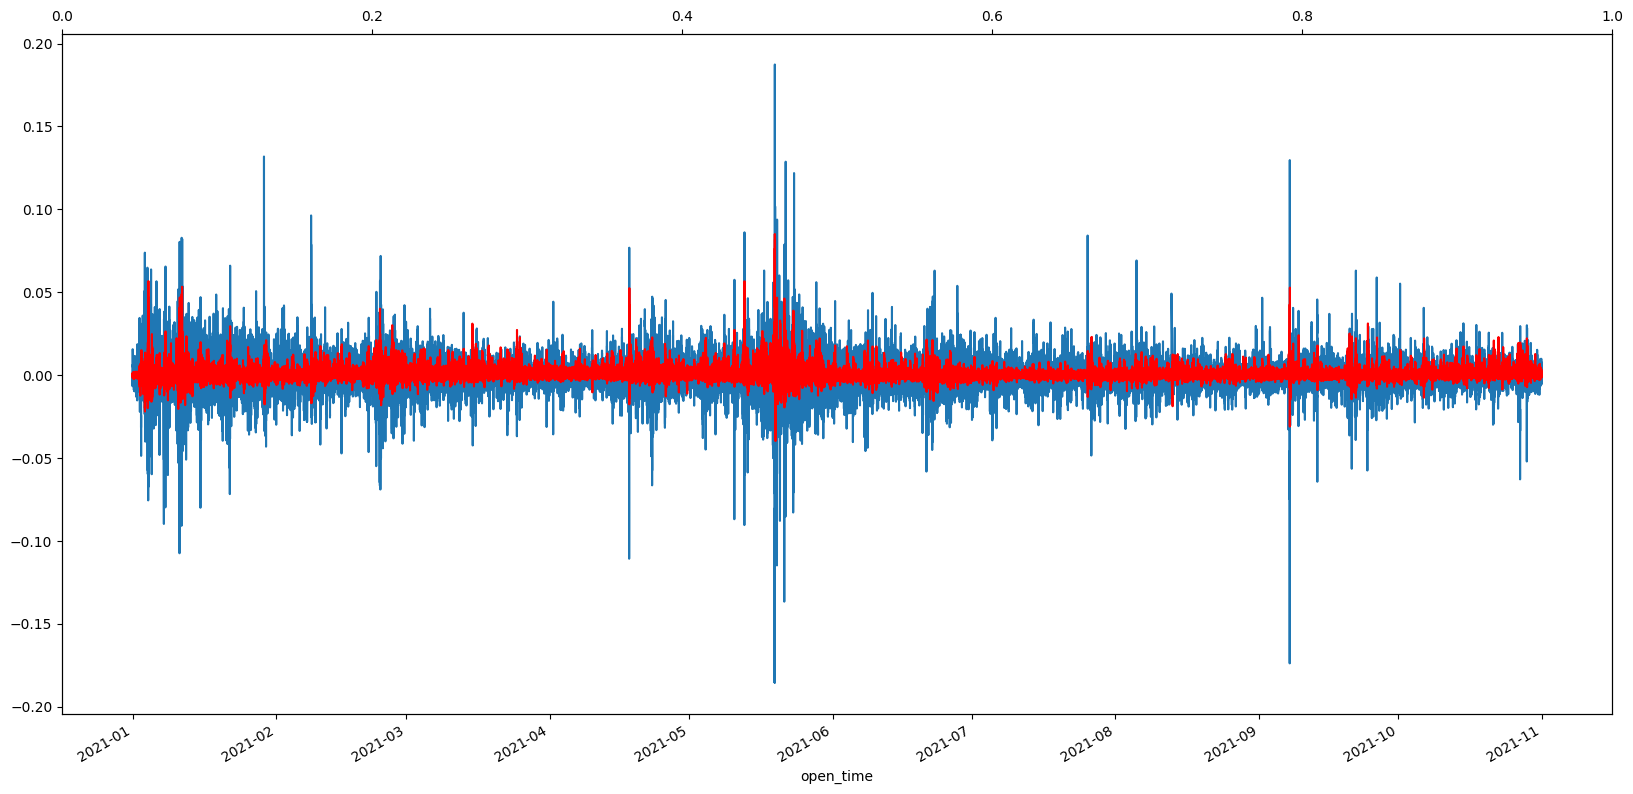

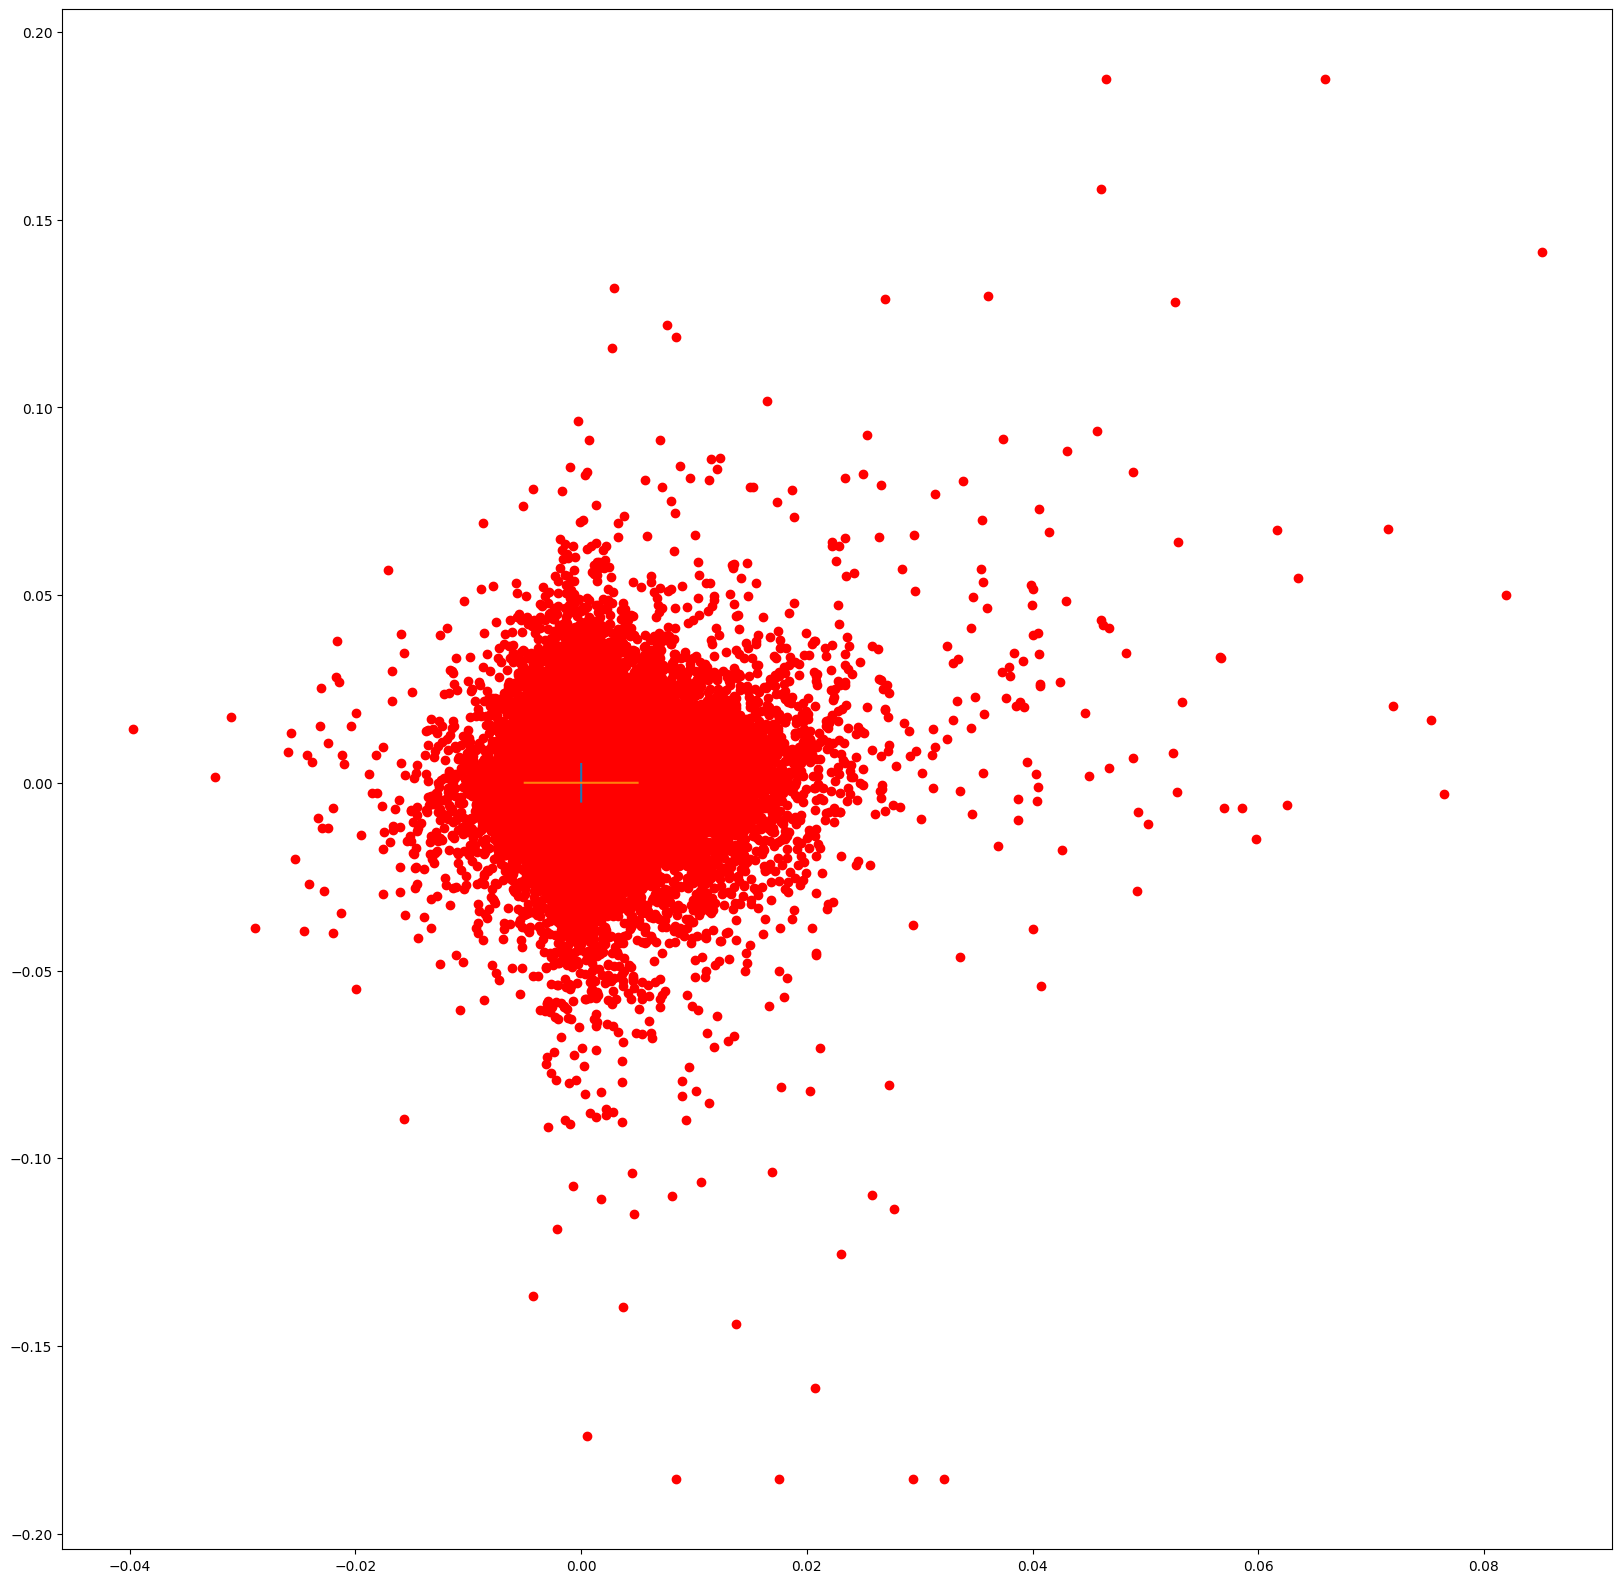

In [41]:
print("样本外")

preds = xgb_reg.predict(X_test)
rmse = np.sqrt(mse(y_test, preds))
print("The out-of-sample RMSE is %0.4f." % (rmse))
print("The out-of-sample R-squared of the XGB regression tree is %0.4f." % r2_score(y_test, preds))

d = pd.DataFrame(preds)
d = d.set_index(df_test.index)
d.columns = ['preds']
d['future_return'] = df_test['future_return']

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twiny()
d['future_return'].plot(ax=ax)
d['preds'].plot(ax=ax,secondary_y=False,color='r')
plt.show()

d = pd.DataFrame(preds)
d = d.set_index(df_test.index)
d.columns = ['preds']
d['future_return'] = df_test['future_return']

fig, ax = plt.subplots(figsize=(20,20))
# d = d.loc['2020-05-19']
x = np.linspace(-0.005,0.005,len(d))
ax.plot([0]*len(d),x)

x = np.linspace(-0.005,0.005,len(d))
ax.plot(x,[0]*len(d))
ax.scatter(x=d['preds'],y=d['future_return'],color='r')
# ax.plot(x,x)
plt.show()

In [42]:
one = len(d[(d['preds']>0) & (d['future_return']>0)])
two = len(d[(d['preds']<0) & (d['future_return']>0)])
three = len(d[(d['preds']<0) & (d['future_return']<0)])
four = len(d[(d['preds']>0) & (d['future_return']<0)])

print("第一象限数量", one)
print("第二象限数量", two)
print("第三象限数量", three)
print("第四象限数量", four)
print("\n")
total = one + two + three + four

print("第一象限占比", one/total)
print("第二象限占比", two/total)
print("第三象限占比", three/total)
print("第四象限占比", four/total)
print("\n")
print("总胜率", (one+three)/total)
print("做多胜率", one/(one+four))
print("做空胜率", three/(two + three))

第一象限数量 50280
第二象限数量 35236
第三象限数量 35012
第四象限数量 46984


第一象限占比 0.3001576006495057
第二象限占比 0.21034910931754142
第三象限占比 0.2090118916853718
第四象限占比 0.28048139834758107


总胜率 0.5091694923348775
做多胜率 0.5169435762460931
做空胜率 0.49840564855938957


In [43]:
a = 0.002
one = len(d[(d['preds']>a) & (d['future_return']>0)])
two = len(d[(d['preds']<-a) & (d['future_return']>0)])
three = len(d[(d['preds']<-a) & (d['future_return']<0)])
four = len(d[(d['preds']>a) & (d['future_return']<0)])

print("第一象限数量", one)
print("第二象限数量", two)
print("第三象限数量", three)
print("第四象限数量", four)
print("\n")
total = one + two + three + four

print("第一象限占比", one/total)
print("第二象限占比", two/total)
print("第三象限占比", three/total)
print("第四象限占比", four/total)
print("\n")
print("总胜率", (one+three)/total)
print("做多胜率", one/(one+four))
print("做空胜率", three/(two + three))

第一象限数量 13727
第二象限数量 5230
第三象限数量 5739
第四象限数量 12074


第一象限占比 0.37332064182757685
第二象限占比 0.1422355180853957
第三象限占比 0.15607832472124014
第四象限占比 0.32836551536578734


总胜率 0.529398966548817
做多胜率 0.5320336421068951
做空胜率 0.5232017503874555


In [44]:
d.describe()

,preds,future_return
count,167579.000000,167579.000000
mean,0.000624,0.000125
std,0.002862,0.008416
min,-0.039757,-0.185501
25%,-0.000583,-0.003393
50%,0.000261,0.000130
75%,0.001284,0.003638
max,0.085119,0.187365


In [ ]:
xgb_reg.feature_importances_

# 超参数调优

In [ ]:
parameters = {
    'n_estimators': [200],
    'eta':np.arange(0,0.9,0.1),
    'gamma': np.arange(0,0.9,0.1),
    'max_depth':np.arange(4,15,1),
    'colsample_bytree': [0.8],
    'colsample_bylevel':[0.8],
    'colsample_bynode': [0.8],
    'min_child_weight': np.arange(1,10000,1000),
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'random_state': [666]
}

eval_set = [(X_train, y_train),(X_test, y_test)]
model = xgb.XGBRegressor(objective='reg:squarederror')

Bayes = BayesSearchCV(model , parameters , scoring='neg_mean_absolute_error', cv=5, n_iter=30 , random_state=14)

# clf = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', cv=5)

Bayes.fit(X_train, y_train,eval_set=eval_set, verbose=200)

print(f'Best params: {Bayes.best_params_}')
print(f'Best validation score = {Bayes.best_score_}')

# 保存预测结果

In [ ]:
def save_results(data_path="factors2", save_path="Pred_Data", scaler=scaler, pca=pca, xgb_reg=xgb_reg):
    for csv_file in os.listdir(data_path):
        if csv_file == '.ipynb_checkpoints':
            continue
        if "spot" not in csv_file:
            continue
        print("正在计算：",csv_file)
        df = pd.read_csv(data_path + "/" + csv_file, index_col=0)
        if 'Unnamed: 0.1' in df.columns:
            df = df.drop(columns=['Unnamed: 0.1'])
        
        df['open_time'] = pd.to_datetime(df['open_time'])
#         df = df.set_index(df['open_time'])
#         df2 = pd.read_csv("raw_data/"+csv_file, index_col=0)
#         df2['open_time'] = pd.to_datetime(df2['open_time'])
        
#         df = pd.merge(df,df2,on=['open_time','open','high','low','close','volume'],how='inner')
        df_result = df.copy()
        df['r1'] = df['close'].pct_change()
        df['r2'] = df.close/df['close'].shift(2) - 1
        df['r5'] = df.close/df['close'].shift(5) - 1
    
        df = df.drop(columns=['open','high','low','close','volume','open_time'])
        print("标准化……")
        

        
        for col in df.columns:
            df[col] = df[col].replace(np.inf, 1000)
            df[col] = df[col].replace(-np.inf, -1000)
            df[col] = df[col].replace(np.nan, 0)
        df = df.drop(columns=['Unnamed: 0'])

            
        print(df.columns)
        df = pd.DataFrame(scaler.transform(df.values), columns=df.columns)
        
        print("降维……")
        new_features = pca.transform(df.values)
        df = pd.DataFrame(new_features, columns = ['alpha'+str(x+1) for x in range(new_features.shape[1])])
        
        print("计算预测值……")
        preds = xgb_reg.predict(df)
        df_result = df_result[['open','high','low','close','volume','open_time']]
        print(len(preds))
        print(len(df_result))
        df_result['preds'] = preds
        
        print("计算ATR……")
        df_result['atr'] = ATR(df_result.high, df_result.low, df_result.close, 288 * 30)
        
        print("保存中……")
        df_result.to_csv(save_path + "/" + csv_file)
        print("完成！")

In [ ]:
save_results()

In [ ]:
preds